<a href="https://colab.research.google.com/github/katamaiah/GENAI/blob/main/MB_T2I_PixxelCraftAI_S3_SKH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction - Text to Image Generation

Starting a digital marketing campaign for a given product or service consists of multiple steps such as identifying the target audience, designing captivating content in form of text and images, launching the campaign, and analyzing its effectiveness.

In recent years, addition of new features to digital marketing campaigns such as Google AdSense and Facebook Ads has streamlined the process of launching and analyzing a digital marketing campaign. Other products that build on top of APIs provided by these advertising companies provide ways to launch omnichannel marketing campaigns and provide centralised dashboards to analyse all the data in one place. But the ideation and content creation steps that come before the campaign launch still require considerable effort on the part of the digital marketing professional.

Based on this, we arrive at the question that motivates the exercise that we are going to cover in this session:

> How can we use generative AI to do ideation and content creation in digital marketing?

So far, you have learned how diffusion models work and how to use those diffusion models to generate images. In this session, you will learn about using diffusion models along with language models to solve real-world problems.

# PixxelCraftAI

---



## Problem Statement

We can describe the problem statement more specifically as follows:
> Design a system that can interactively take in information from the user about a digital marketing campaign and use that to generate a call to action and an image.

There will be three stages in this project:
- Stage 1: Extracting information from the user
- Stage 2: Generating the call to action (CTA) and the image description
- Stage 3: Generate an image using the description

Let's look at these stages in more detail.

In stage 1, we want the LLM to extract two pieces of information about the marketing campaign, a description of the **product** that we want to market and a description of the **target group** for which the product is being marketed. For example, a product could be a "*mutual fund offering*" and a target audience could be "*young professionals of ages 25-35 living in tier-1 cities in India*".

In stage 2, we will use the information extracted in the first stage to create a CTA and an image description. A CTA in a digital marketing campaign refers to the next step that the marketer wants their audience or reader to take. The image description generated in this stage should be relevant to the product that we are trying to market and the target audience. Both the CTA and the image description should be relevant to the product being described and the target audience. For example, a CTA could be "*Watch your hard earned money grow in a safe and reliable way. Invest in one of our variety of mutual fund offerings!*" and the image description could be "*An image of a young professional holding a laptop, with a backdrop of a bustling city*"

Finally, in stage 3, we will use Stable Diffusion to generate an image from this description. Here, you will load a Stable Diffusion model like you did in the previous session and provide it with a positive and a negative prompt to generate the image that you want.

We can look at the system design of our program in the diagram given below.

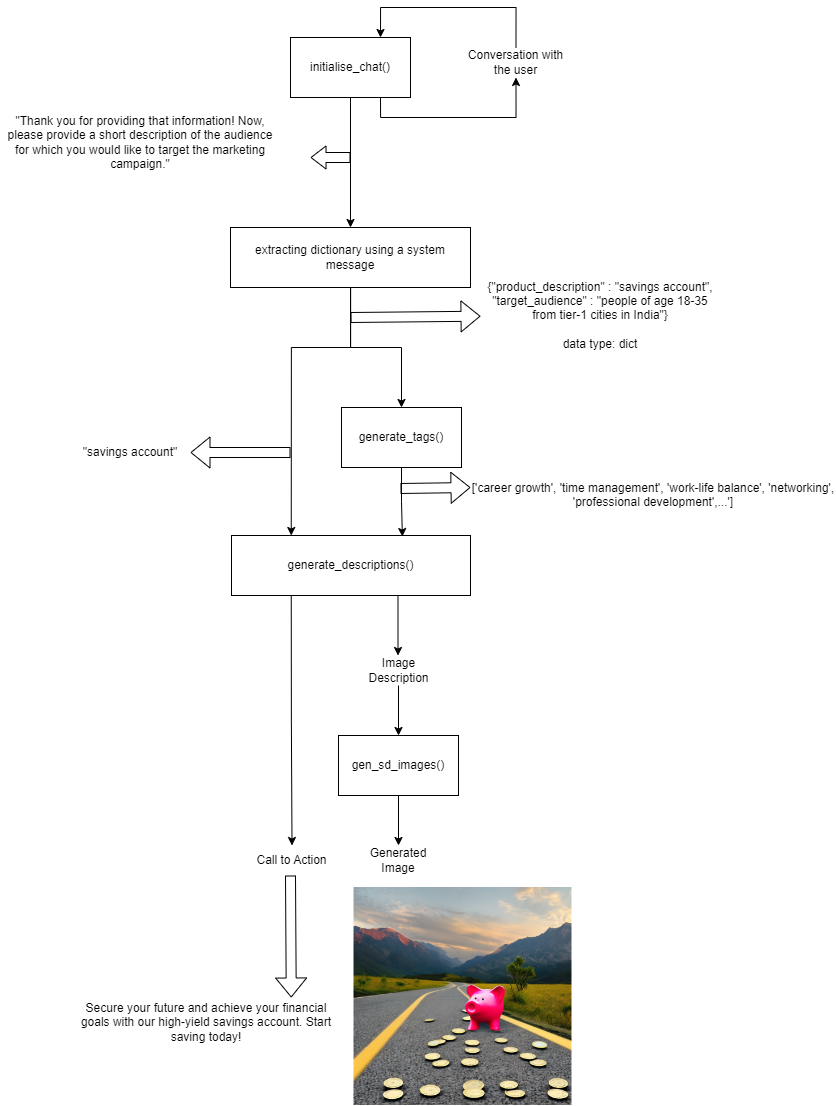

The major functions in the flowchart are described as follows:

* `initialize_chat()`
  - It returns a conversation list that can be sent into the `chatCompletions.create()` method.

* `generate_tags()`
  - It returns a list of tags relevant to the target audience a *ChatCompletion* call.
* `generate_descriptions()`
  - It takes in information about the product and tags about the target audience and returns a call to action and an image description that can later be used as a prompt
* `gen_sd_image()`
  - It generates an image using the improved image description that we obtained from our language model instance.

You can keep coming back to this image to locate yourself in the code. Let's now move on to the first stage.

## Stage 1: Information Extraction
As discussed before, in this part, we will use a language model to extract relevant information about the digital marketing campaign from the user. We will use the ChatGPT API for this. There will be four tasks in this stage:
- Task 1: Setup
- Task 2: Initialising the chat
- Task 3: Mimicking a chat with a user
- Task 4: Parsing the final output

Let's now move on to the first task.

### Task 1: Setup

In this task, we will:

1. Connect Colab to a GPU runtime
2. Install relevant Python modules (on-demand in various sections of the code)
3. Import relevant libraries (on-demand in various sections of the code) and setup the OpenAI API
4. Define a simple function to access the *ChatCompletion* method

Before going ahead, make sure that your Colab instance is connected to a GPU runtime. Otherwise you risk data loss.

Let's start by installing the OpenAI library so that we can access the language model calls.

In [ ]:
# Install the OpenAI library
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.2 MB/s eta 0:00:00


After installing the required libraries, we will import the libraries we will need in this stage of the program.

In [ ]:
# Import 'ast' to parse strings to dictionaries
import ast

# Import the OpenAI API
import openai

# Import 're' to use regular expression functions for text processing
import re

After importing the libraries, let's set up the OpenAI API by providing it the appropriate API key. This OpenAI API key can be accessed from your OpenAI Dashboard. Save it in a file called `'api_key.txt'`.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the API key
filepath = "/content/drive/MyDrive/upgrad/helpmate/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

Now let's define a function that can be used to access the *ChatCompletion* method.

In [ ]:
# Define a function that interacts with the ChatCompletion API
def get_chat_model_completions(messages):
    response = openai.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=messages
    )
    return response.choices[0].message

This cell defines a function named `get_chat_model_completions` that interacts with the OpenAI ChatCompletion API to generate text completions or responses based on a list of messages provided as input. The purpose of this code is to obtain a response from the GPT-3.5-turbo model for a given conversation.

Here's a breakdown of how the code works:

1. **Function Definition**: The code starts by defining a function named `get_chat_model_completions` which takes a single parameter called `messages`.

2. **API Request**: Inside the function, an API request is made to the ChatCompletion API using the `openai.ChatCompletion.create()` method. This method sends a request to the API for generating a completion based on the provided conversation messages.

    - `engine = _chat`: `_chat` is a variable containing the engine ID to specify which model to use. This is specific to the OpenAI setup and has been defined above.

    - `messages = messages`: The `messages` parameter contains a list of message objects representing the conversation history. Each message object has two properties: `role` (which can be "system", "user", or "assistant") and `content` (the text of the message).

    - `model = 'gpt-3.5-turbo'`: This specifies the specific GPT model variant to use for generating the completion. In this case, it's using the "gpt-3.5-turbo" model, which is an optimized variant of the GPT-3.5 model for faster responses.

    - `max_tokens = 3000`: This parameter limits the length of the generated completion to 3000 tokens. Tokens are chunks of text, which could be as short as one character or as long as one word.

4. **Response Handling**: The API response is stored in the `response` variable. The code then extracts the message content from the first choice in the response using `response.choices[0].message`. The API response includes a list of possible completions, and the code is choosing the first one.

5. **Return Value**: The function returns the generated response message. This message can be used in your application as a completion to the provided conversation.

Recall that the `messages` in this function needs to be a list of dictionaries where each dictionary has two keys: `"role"` and `"content"`. Let's test this function!

In [ ]:
get_chat_model_completions([{'role': 'user', 'content': 'Tell me a joke!'}])

ChatCompletionMessage(content='Why did the tomato turn red? Because it saw the salad dressing!', refusal=None, role='assistant', function_call=None, tool_calls=None)

We have now finished the first task in this session, **Setup**. Let's move on to the next task.

### Task 2: Initialising the chat

So far, we have installed and imported required libraries, setup the OpenAI API and defined a simple function that can be used to access it. Now, we will move into the main task at this stage in which we will initialise the chat.

Recall that the `ChatCompletion.create()` method requires you to pass a list of dictionaries in which each dictionary represents a message. Each message has a role attached to it and the model has three roles built into it: 'system', 'assistant', and 'user'. The 'assistant' role is used for messages that the chatbot sends, as you saw above, the 'user' role is used with messages that the user sends to the chatbot, and finally, the 'system' role is used to setup and initialize the chatbot. This is what we mean to accomplish in this task: setup and initialize the chatbot.

We will write a prompt in which we will clearly describe the chatbot's role and task. We will enhance that prompt by providing a chain of thought reasoning, providing few-shot examples, and using delimiters to demarcate important parts of the prompt.

The prompt can be arrived at through an iterative process, but for the purpose of this demonstration, we can simply use the given prompt, analyze it to learn how it works. Specifically, let's examine the following parts of the prompt:

1. Chatbot's role
2. Chatbot's task
3. Output format
4. Chain of thought reasoning
5. Few-shot examples

We will define a function `initialise_chat()` that returns a `conversation` list that can be sent into the `ChatCompletion.create()` method.

In [ ]:
# Define a function that extracts information from the user's response using the ChatCompletion API
def initialize_chat():

    # Use a delimiter to split the prompt into parts
    delimiter = "####"

    # Describe the chatbot's role, a chain of thoughts, and few shot examples
    tags_prompt = f"""You are a digital marketing professional who is responsible for designing a marketing campaign for a product targeted for a specific target group.
    You need to interact with the user to extract information about the following things:
    1. Description of product that is being marketed
    2. Description of the target audience

    {delimiter}
    You will go through the following chain of thoughts to extract information and save it in the format given:
    Thought 1. Start with a message introducing yourself and saying that you will ask two questions to understand the product and the target audience. Ask the user to say something to continue the chat.
    Thought 2. If the user says yes, ask the user to describe the product.
    Thought 3. Ask the user about the target audience.
    Thought 4. Thank the user for providing the information and ask them to wait for their call to action and marketing image.
    {delimiter}

    {delimiter}
    Here is a sample conversation for you to learn from.
    {delimiter}

    Sample conversation 1:
    Assistant: Hello, I am a marketing professional, I can help you with the creation of a marketing campaign. I will need to ask you a few questions for that. Would you like to continue?
    User: Yes, continue.
    Assistant: Please provide a short description of the product that you would like to market.
    User: I would like to market a savings bank account.
    Assistant: Thank you for providing that information! Please provide a short description of the audience for which you would like to target the marketing campaign.
    User: I want to target this product to people of the age group 18-35 who live in tier-1 cities in India.
    Assistant: Thank you for providing this information. Please wait for your call to action text and marketing image.
    {delimiter}

    {delimiter}
    Sample conversation 2:

    Assistant: Hello, I am a marketing professional, I can help you with the creation of a marketing campaign. I will need to ask you a few questions for that. Would you like to continue?
    User: Yes, continue.
    Assistant: Please provide a short description of the product that you would like to market.
    User: I would like to market a home loan.
    Assistant: Thank you for providing that information! Please provide a short description of the audience for which you would like to target the marketing campaign.
    User: I want to target this product to people of the age group 35-50 who live in tier-2 cities in India.
    Assistant: Thank you for providing this information. Please wait for your call to action text and marketing image.
    {delimiter}


    """

    # Save the system message in the correct format
    chat_initializer = [{'role': 'system', 'content': tags_prompt}]

    return chat_initializer

Let's now check the output of this function to see the first message that needs to be sent to `ChatCompletion.create()`.

In [ ]:
print(initialize_chat()[0]['content'])

You are a digital marketing professional who is responsible for designing a marketing campaign for a product targeted for a specific target group.
    You need to interact with the user to extract information about the following things:
    1. Description of product that is being marketed
    2. Description of the target audience

    ####
    You will go through the following chain of thoughts to extract information and save it in the format given:
    Thought 1. Start with a message introducing yourself and saying that you will ask two questions to understand the product and the target audience. Ask the user to say something to continue the chat.
    Thought 2. If the user says yes, ask the user to describe the product.
    Thought 3. Ask the user about the target audience.
    Thought 4. Thank the user for providing the information and ask them to wait for their call to action and marketing image.
    ####

    ####
    Here is a sample conversation for you to learn from.
    ####



### Task 3: Mimicking a chat

In this task, we will:
1. Define a function that can be used to interact with the chatbot.
2. Try out a few different combinations of product descriptions and target audiences to test the chatbot's information extraction capabilities.

Let's first pass the system message to the chatbot and print its response.

In [ ]:
# Initialize chat and save the system message in conversation
conversation = initialize_chat()

# Get the first message from the API
response = get_chat_model_completions(conversation)

In [ ]:
# Print the assistant's message
print(response)

ChatCompletionMessage(content='Hello, I am a marketing professional, I can help you with the creation of a marketing campaign. I will need to ask you a few questions for that. Would you like to continue?', refusal=None, role='assistant', function_call=None, tool_calls=None)


We can see that the response has the `'role'` set to `'assistant'` and the `'content'` is the first message in the chat. To continue, we need to append response into the conversation list.

In [ ]:
conversation.append(response)

To continue the chat, we need to:
1. Take an input from the user.
2. Save the input as the value of the `'content'` key in a dictionary with the `'role'` key set to `'user'`.
3. Append this dictionary in the conversation list.
4. Get a response from the ChatCompletions model
5. Append the response into the conversation list.

In [ ]:
def get_response(prompt, conversation):
    user_response = {'role': 'user', 'content': prompt}
    conversation.append(user_response)
    response = get_chat_model_completions(conversation)
    conversation.append(response)
    return conversation

We can use the function get response to send '*Yes*' to the chatbot.

In [ ]:
conversation = get_response('Yes', conversation)

To access the response of the chatbot, we can print the last item in the conversation list.

In [ ]:
print(conversation[-1])

ChatCompletionMessage(content='Please provide a short description of the product that you would like to market.', refusal=None, role='assistant', function_call=None, tool_calls=None)


In this way, we can continue the whole conversation with the chatbot.

In [ ]:
conversation = get_response('I want to create a marketing campaign for a savings account', conversation)

In [ ]:
print(conversation[-1])

ChatCompletionMessage(content='Thank you for providing that information! Please provide a short description of the audience for which you would like to target the marketing campaign.', refusal=None, role='assistant', function_call=None, tool_calls=None)


In [ ]:
conversation = get_response('I want to target working professionals in tier-2 cities in india of ages between 30 and 55 years', conversation)

In [ ]:
print(conversation[-1])

ChatCompletionMessage(content='Thank you for providing this information. Please wait for your call to action text and marketing image.', refusal=None, role='assistant', function_call=None, tool_calls=None)


Now that we have taken all the information from the user in the form of a chat, we need to extract information about product description and target audience in the form of a Python dictionary. Let's do that next.

### Task 4: Extracting the dictionary
In this task, we need to extract information about the product description and target audience with the help of another message with the "system" role. Recall that we used a message with the "system" role to set up the chatbot. Similarly, we can use more system messages to perform actions that pertain to the whole conversation. For example, in this case, we will use it to extract information about the product and the target audience.

In the absence of this functionality, we would have had to use regular expressions to extract this information from a chat message sent by the chatbot in the "assistant" role.

Let's extract the dictionary from the chat. We will start by writing a prompt that can be used to extract infromation from the conversation.

In [ ]:
prompt = """You are a seasoned marketing proffessional. Your job is to review a given conversation and extract information about the product description and the target audience that a customer wants to aim.
            Return that information in the JSON format with the keys "product_description" and "target_audience". Please don't provide any text beside this information."""

In [ ]:
system_response = {'role': 'system', 'content': prompt}
conversation.append(system_response)
response = get_chat_model_completions(conversation)
dictionary_str = response.content
print(dictionary_str)

{
    "product_description": "I want to create a marketing campaign for a savings account",
    "target_audience": "I want to target working professionals in tier-2 cities in India of ages between 30 and 55 years"
}


In [ ]:
type(dictionary_str)

str

We have successfully extracted the dictionary from the final message, but it is still a string. Next, we will convert this string into a dictionary and save the target_audience and product description in different variables.

In [ ]:
# Convert the output into dictionaries and save it into variables
product_description = ast.literal_eval(dictionary_str)['product_description']
target_audience = ast.literal_eval(dictionary_str)['target_audience']

In [ ]:
print(product_description)

I want to create a marketing campaign for a savings account


In [ ]:
print(target_audience)

I want to target working professionals in tier-2 cities in India of ages between 30 and 55 years


We have now successfully extracted the product description and the target audience to be used for the marketing campaign. Let's try to create images using this information.

Let's try to create an image with the basic generator function.

But before we do that, we need to setup the Colab environment so that we can run Stable Diffusion on it. You must be familiar with this code from previous sessions.

Make sure that you are connected to a T4 GPU on colab. You can connect to a GPU using the menu as follows:

> Runtime > Change runtime type > Hardware Accelerator: GPU

By default, Colab will connect you to an NVIDIA Tesla-4 GPU. After connection, let's first check the GPU stats.

In [ ]:
# Get output from the NVIDIA system management interface
!nvidia-smi

Sun Sep 22 10:59:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Install libraries that will be used to access diffusion models to generate images
!pip install -qU diffusers==0.11.1
!pip install -qU transformers scipy ftfy accelerate
!pip install -qU invisible_watermark safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 92.7 MB/s eta 0:00:00


In [ ]:
# added

!pip uninstall jax jaxlib -y
!pip install jaxlib

Found existing installation: jax 0.4.26
Uninstalling jax-0.4.26:
  Successfully uninstalled jax-0.4.26
Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
  Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 MB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires jax>=0.4.16, which is not installed.
dopamine-rl 4.0.9 requires jax>=0.1.72, which is not installed.
optax 0.2.2 requires jax>=0.1.55, which is not installed.
orbax-checkpoint 0.6.4 requires jax>=0.4.26, which is not installed.


In [ ]:
# Set up and initialize the Stable Diffusion pipeline
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-1', torch_dtype=torch.float16)
pipe = pipe.to('cuda')

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

text_encoder/pytorch_model.fp16.safetensors not found


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Running this cell takes a while as we need to download and initialise a pretrained Stable Diffusion model.

We can then define our custom image generator function described below.

In [ ]:
# Define a custom function that takes in a prompt, a negative prompt and a seed value for reproducibility
# Note: Other parameters such as number of inference steps, guidance scale, image dimensions, and so on are fixed
# Note: We will predefine our negative prompt based on what we know already from previous sessions
import random
import math

def gen_sd_img(prompt, negative_prompt, seed = None):
    rnum = math.floor(random.random() * 1_000_000_000)
    fseed= rnum
    if(seed != None):
        fseed = seed
    image = pipe(prompt = prompt,
                 negative_prompt = negative_prompt,
                 num_inference_steps = 20,
                 guidance_scale = 9,
                 height = 768,
                 width = 768,
                 num_images_per_prompt = 1,
                 generator = torch.Generator('cuda').manual_seed(fseed)).images[0]
    return image

You may have seen this function before in another session. But here is a description of each parameter:
- *prompt*: This is the text input that is used to generate a new image
- *negative_prompt*: This is the text input that is used to suppress parts of the output image
- *num_inference_steps*: This is the number of inference steps that SD executes before returning an output image
- *guidance_scale*: This is a value that controls how closely generated images follow the input prompts
- *height*: This is the height of the output image in number of pixels
- *width*: This is the width of the output image in number of pixels
- *num_images_per_prompt*: This is the number of images to be generated for a single input prompt
- *generator*: This is used to generate pseudorandom numbers
- *seed*: The parameter used to generate a random vector from which to produce an image

Let's try to generate an image using the custom image generation function using the information extracted by our language model.

We also know that image models generally produce bad image components when it comes to text and human faces, so we will include these in the negative prompt.

In [ ]:
print(product_description)

I want to create a marketing campaign for a savings account


In [ ]:
print(target_audience)

I want to target working professionals in tier-2 cities in India of ages between 30 and 55 years


In [ ]:
product_description + ' for ' + target_audience

'I want to create a marketing campaign for a savings account for I want to target working professionals in tier-2 cities in India of ages between 30 and 55 years'

  0%|          | 0/20 [00:00<?, ?it/s]

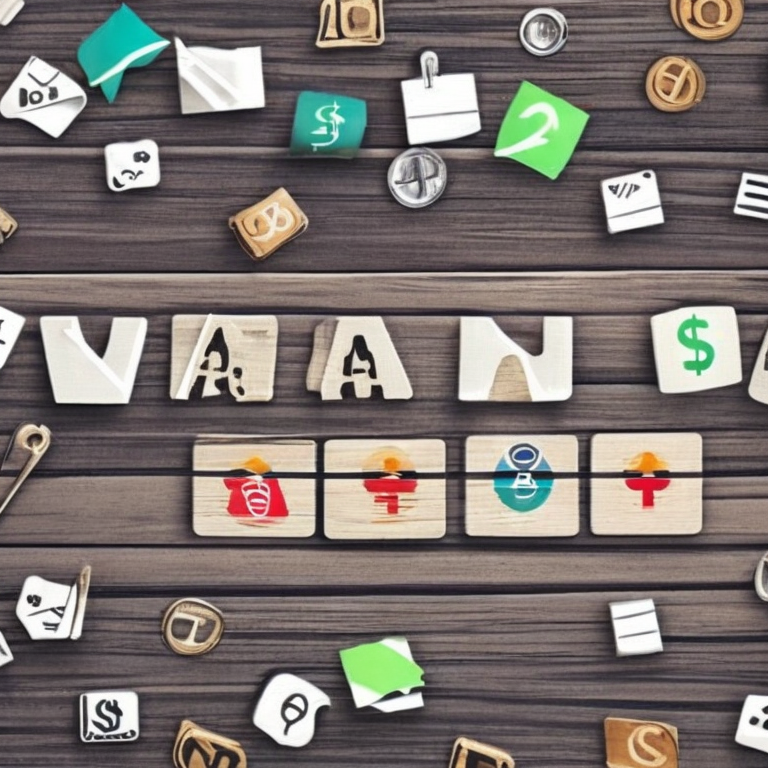

In [ ]:
gen_sd_img(prompt = product_description + ' for ' + target_audience,
           negative_prompt = 'pig',
           seed = 23)

In general, we can see that the image that is generated is quite bad and irrelevant. This is because the image model does not understand language the way language models do. You saw this in previous sessions. Therefore, we need to convert the information extracted by the language model into information that is well understood by the image model.

Note that entering negative prompts at this stage is not very impactful because our actual positive prompt is not good enough anyway. We can add negative prompts later.

In the next stage however, we will try to improve the main prompt for the image model by using more language model instances.

## Stage 2: Generating the CTA and the Image Description

At the of the last task, we directly sent information about the target audience and the product description into the StableDiffusion model. The image model gave us an output, but it was not relevant. Plus we need to create a CTA text along with the image. Therefore, we will use another ChatGPT API call to generate a CTA and an image description.

We could directly use the target audience and the product description to create the two things that we need. But to provide a better context to the model while creating the CTA and the image description, we will generate a few tags that describe the target audience in a well-rounded way.

To summarize, in this stage of the project, we will:
- Task 5: Generate tags to describe the target audience
- Task 6: Generate descriptions (CTA and image description)

### Task 5: Generating tags

In this part, we will define a function that will generate a few keywords that can describe the target audience using a *ChatCompletion* call.

In [ ]:
def generate_tags(target_audience):
    '''Returns a list of tags relevant to the target audience'''

    # Define a format string to illustrate the expected tag format
    format = "['tag1', 'tag2', 'tag3', ...]"

    # Define a delimiter for formatting purposes
    delimiter = '####'

    # Create a prompt for the chatbot to provide tags for a specific target audience
    tags_prompt = f"""Your task is to provide 10 tags for people from the target group described in {target_audience}

    {delimiter}
    Provide your response in the following format: {format}"""

    # Use a chat model to get completions for the tag prompt
    tag_string = get_chat_model_completions([{'role': 'system', 'content': tags_prompt}])

    # Convert the response from the chat model into a Python list using ast.literal_eval
    # The response content is assumed to be a string representation of a list
    tags = ast.literal_eval(tag_string.content)

    # Return the extracted tags
    return tags


In [ ]:
extracted_tags = generate_tags(target_audience)

In [ ]:
print(extracted_tags)

You can see that these tags are more descriptive than the target audience that was extracted from the user's input. We will now move on to the next task, that is generating a new image description from these tags, as well as generating the CTA.

### Task 6: Generating descriptions

In this part, we will generate a CTA and an image description that can be sent to an image model later.

In [ ]:
def generate_descriptions(product, tags):
    '''Takes in information about the product and tags about the target audience
    and returns a call to action and an image description that can later be used as a prompt.'''

    # Provide a format for the output
    format = '{"cta": "call to action", "image": "image description"}'

    delimiter = "####"

    # Provide a template for our prompt and few-shot examples
    descriptions_prompt = f"""You are an expert Marketing Manager.
    Develop a marketing campaign for {product}, targeting the specified audience {tags}. The task includes crafting:

    A call-to-action (CTA) phrase, concise yet compelling, under 200 characters, to motivate the audience to engage with {product}.
    An image description for AI-generated visual content, adhering to the following criteria: no depiction of humans, faces, hands, or text, and succinctly encapsulate the product's appeal in under 100 words.
    Format your response as specified in {format}, ensuring both elements are concise and effectively communicate the campaign
    """

    # Get a response from the ChatCompletion API
    marketing_descriptions = get_chat_model_completions([{'role': 'system', 'content': descriptions_prompt}])

    # Convert the response into a dictionary
    descriptions = ast.literal_eval(marketing_descriptions.content)
    return descriptions

GPT 3.5 doesn't know Stable Diffusion because its knowledge base ends in September 2021. That's why we are using "image generation AI models" as a stand in for Stable Diffusion.

We are asking the chatbot to avoid image descriptions that contain faces and hands because currently, StableDiffusion isn't capable of creating faces and hands properly. Plus, we want to create our own text, so we can avoid any text in the image.

In [ ]:
# Save the description into a variable
descriptions = generate_descriptions(product_description, extracted_tags)

In [ ]:
print(descriptions)

You can see that the chat completion model has created a CTA and an image description. Let's now move to the next stage of this project by using this image description to actually create an image.

## Stage 3: Generate an Image

In this stage of the project, we will use the image description created above, to generate an image using the StableDiffusion pipeline that you're familiar with.

### Task 7: Generating an image
Let's now generate an image using the improved image description that we obtained from our language model instance.

In [ ]:
descriptions['image']

In [ ]:
gen_sd_img(prompt = descriptions['image'],
           negative_prompt = 'none',
           seed = 23)

You can try generating new descriptions and images if you are not satisfied with this image. You can also try adding some negative prompts if required.

In [ ]:
gen_sd_img(prompt = descriptions['image'],
           negative_prompt = "text, face, ugly, low-quality",
           seed = 23)

Let's try with another random seed number.

  0%|          | 0/20 [00:00<?, ?it/s]

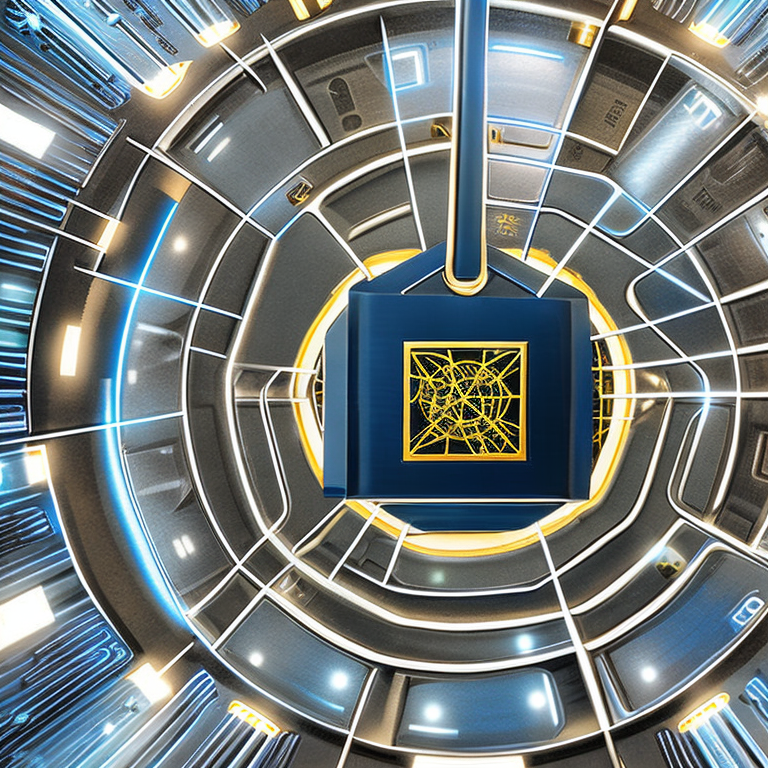

In [ ]:
gen_sd_img(prompt = descriptions['image'],
           negative_prompt = "text, face, ugly, low-quality",
           seed = 3786598)

In [ ]:
gen_sd_img(prompt = descriptions['image'],
           negative_prompt = "text, face,ugly, low-quality",
           seed = 11212)

This brings us to the end of this project. You can extend this project by:
1. Creating a UI for this chatbot
2. Manually iterating on the prompt to create a better image and taking in negative prompts from the user
3. Using a pre-tuned checkpoint instead of the base Stable Diffusion model
4. Using another image generation model
5. Improve the artistic effects of the creative
6. Use keyword weighting in the prompt generation